In [1]:
from pyspark.sql import SparkSession
import os


In [2]:


local=True
if local:
    spark = SparkSession.builder\
        .master("local[4]")\
        .appName("RepartitionAndCoalesce")\
        .config("spark.executor.memory", "4g")\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .getOrCreate()
else:
    spark = SparkSession.builder\
        .master("k8s://https://kubernetes.default.svc:443")\
        .appName("RepartitionAndCoalesce")\
        .config("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")\
        .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT'])\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .config("spark.executor.instances", "4")\
        .config("spark.executor.memory","2g")\
        .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])\
        .getOrCreate()

# make the large dataframe show pretty
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

23/09/27 15:13:01 WARN Utils: Your hostname, pengfei-Virtual-Machine resolves to a loopback address: 127.0.1.1; using 10.50.2.80 instead (on interface eth0)
23/09/27 15:13:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/pengfei/opt/spark-3.3.0/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pengfei/.ivy2/cache
The jars for the packages stored in: /home/pengfei/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-64ea0315-bd3f-4f81-ba9f-ca37fa789610;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 393ms :: artifacts dl 12ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	------------------------------

23/09/27 15:13:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [11]:
from pyspark.sql import Row

vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50),
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])

edges = spark.createDataFrame([('1', '2', 'friend'),
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])


In [12]:
from graphframes import GraphFrame

graph = GraphFrame(vertices, edges)


/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [13]:
graph.vertices.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+


In [14]:
graph.edges.show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+


KeyError: 'type'

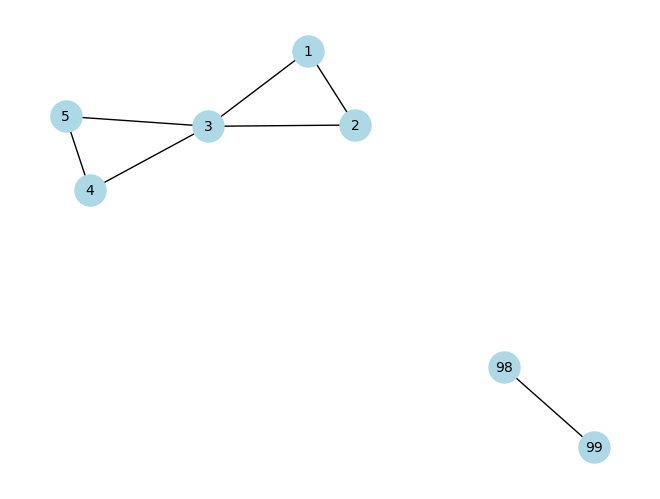

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the GraphFrame to a NetworkX graph manually
nx_graph = nx.Graph()
for edge in graph.edges.collect():
    nx_graph.add_edge(edge["src"], edge["dst"])

# Define layout
pos = nx.spring_layout(nx_graph, seed=42)

# Draw nodes and edges
nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
labels = {edge: data["type"] for edge, data in nx_graph.edges.items()}
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=labels)

plt.show()


When we try to create different types of nodes in a graphe, we have difficulties. Because we use one data frame to build the vertexs. And a dataframe can't have two different schema. I found a https://stackoverflow.com/questions/33241332/how-to-create-a-bipartite-graph-in-graphx

It uses RDD to do the job. Need to test if possible with python.

Another solution is to build a parent Class which can be subclass for the different node type. In our case, if there are a patient type node, and a doctor type node. We need to create a person class which contains not only all required attributes of doctor and patient, but also an extra attribute such as `profession` which distinct the patient and doctor

In [23]:
# Define vertices for partite A
patients = spark.createDataFrame([
   ("patient 1", 12, "1st rue toto"),
   ("patient 2", 26, "1st rue t1t1"),
   # Add more vertices for partite A as needed
], ["name","age","address"])

# Define vertices for partite B
docs = spark.createDataFrame([
   ("doctor1", "hospital1", "2 rue toto"),
   ("doctor2", "hospital2", "3 rue toto"),
   # Add more vertices for partite B as needed
], ["name", "hospital_name", "hostpital_address"])

# Define edges connecting partite A to partite B
edges = spark.createDataFrame([
   (1, 101, "see doctor"),
   (2, 102, "see doctor"),
    (1, 102, "see doctor"),
   (2, 101, "see doctor"),
   # Add more edges as needed
], ["src", "dst", "relationship"])

# Create GraphFrames for partite A and B
graph_A = GraphFrame(patients, edges)
graph_B = GraphFrame(docs, edges)

# Merge the vertices and edges of both GraphFrames to create a bipartite graph
merged_vertices = patients.union(docs)
merged_edges = edges
bipartite_graph = GraphFrame(merged_vertices, merged_edges)



ValueError: Vertex ID column id missing from vertex DataFrame, which has columns: name,age,address

KeyError: 'type'

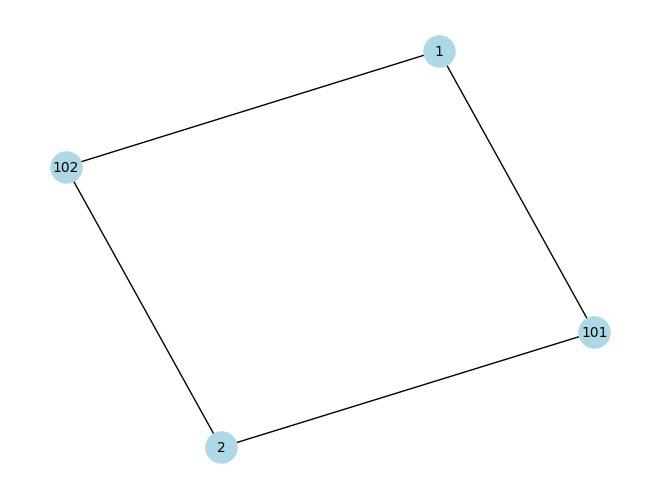

In [22]:
nx_graph = nx.Graph()
for edge in bipartite_graph.edges.collect():
    nx_graph.add_edge(edge["src"], edge["dst"])

# Define layout
pos = nx.spring_layout(nx_graph, seed=42)

# Draw nodes and edges
nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
labels = {edge: data["type"] for edge, data in nx_graph.edges.items()}
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=labels)

plt.show()